# Chapter 4. Stokes Vector Fields
See also M-Sec. 5 and S-Sec. 4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.transform import Rotation as scipyRotation
from IPython.display import display
import polarsh as psh
from utils import plot_text_only
psh.set_visoptions_vispy(title_size = 12, arrow_size=0.1)

## 4.1. `SphereFrameField` class
Core attributes:
* `.SphGrid: SphereGrid` ([*g] for shape)
* `.dom_type: DomType`
* case `.dom_type == DomType.UNI`:
    * `.F: np.ndarray[*g, 3, 3]`
* case `.dom_type != DomType.UNI`:
    * `.Fi: np.ndarray[*g, 3, 3]`
    * `.Fo: np.ndarray[*g, 3, 3]`

In [2]:
# ---------- Parameters ----------
edge = 6
h, w = 10, 20
to_world = np.eye(3)

# ---------- Main ----------
sphG = psh.SphereGridCube(edge)
sphFF = sphG.ThetaPhiFrameField()
# `sphFF` is equivalent to `SphereFrameField(sphG, sphFF.F)`
print(f"{type(sphFF) = }")
print(f"{sphFF = }")
print(f"{sphFF.F.shape = }")
assert sphFF.SphGrid is sphG
assert sphFF.shape == sphG.shape
assert np.allclose(sphFF.F[..., 2], sphG.vec)

type(sphFF) = <class 'polarsh.grid.Grid.SphereFrameField'>
sphFF = SphereFrameField[
  dom_type = <DomType.UNI: 0>,
  shape = [6, 6, 6],
]
sphFF.F.shape = (6, 6, 6, 3, 3)


**Several conventions of frame fields**
* $\theta\phi$-frame field
  * $\vec{\mathbf F}_{\theta\phi}\left(\hat\omega\right)$ or $\vec{\mathbf F}_{\theta\phi}\left(\theta,\phi\right)$ in S-Eqs. (12, 91)
  * [`polarsh`] `psh.SphereGrid.ThetaPhiFrameField()`, `psh.SphereFrameField.from_equirect()`
  * Singularity: $\hat\omega=\pm \hat z_{g}=\vec {\mathbf F}_g\left[0,0,\pm 1\right]^T$.
* Perspective frame field
  * $\vec{\mathbf F}_{\mathrm{pers}}\left(\hat\omega;\hat u\right)$ in S-Eq. (13)
  * [`polarsh`] `psh.SphereGrid.PerspectiveFrameField()`, `psh.SphereFrameField.from_persp()`
  * Singularity: $\pm \hat u$ where $\hat u$ is the given up vector argument.
  * Following the convention used in [Mitsuba 3](https://www.mitsuba-renderer.org/)
* Cubemap frame field
  * Assinging perspective frame fields for each face of the cubemap with respect to each camera up vector ($\hat u=\vec{\mathbf F}_g\left[0, \pm 1,0\right]$ for the bottom and top faces resp., and $\vec{\mathbf F}_g\left[0, 0, 1\right]$ for the others).
  * [`polarsh`] `psh.SphereGrid.CubemapFrameField()`, `psh.SphereFrameField.from_cube()`
  * Singularity: Edges of the top and bottom faces of the cube, i.e., $\left\{\hat\omega=\vec {\mathbf F}_g\left[x,y,z\right]^T\in\hat{\mathbb S}^2| \left(x=z \wedge \left|y\right|\le \left|z\right|\right)\text{ or }\left(y=z \wedge \left|x\right|\le \left|z\right|\right)\right\}$.
* Geodesic frame field
  * First assign the global frame as a local frame at the north pole: $\vec{\mathbf F}_{\mathrm{geo}}\left(\hat z_g\right)=\vec{\mathbf F}_g$. For other $\hat\omega\in\hat{\mathbb S}^2$, $\vec{\mathbf F}_{\mathrm{geo}}\left(\hat \omega\right)$ is defiend as a parallel transport of $\vec{\mathbf F}_{\mathrm{geo}}\left(\hat z_g\right)$ along the shortest geodesic curve, i.e., $\vec{\mathbf F}_{\mathrm{geo}}\left(\theta,\phi\right)=\vec R_{\hat z_g \hat y_g \hat z_g}\left(\phi, \theta, -\phi\right)\vec{\mathbf F}_g$.
  * [`polarsh`] `psh.SphereGrid.GeodesicFrameField()`, `psh.SphereFrameField.from_mirrorball()`
  * Singularity: only one singularity at $\hat\omega=-\hat z_g = \vec {\mathbf F}_g\left[0,0,-1\right]^T$ with winding number 2.
* [[Tom Duff et al. 2017]](https://graphics.pixar.com/library/OrthonormalB/paper.pdf) frame field
  * For the formula we refer to the original paper: "Building an Orthonormal Basis, Revisited" by
            Tom Duff, James Burgess, Per Christensen, Christophe Hery,
            Andrew Kensler, Max Liani, and Ryusuke Villemin
            (JCGT Vol 6, No 1, 2017)
  * [`polarsh`] `psh.SphereGrid.TD17FrameField()`
  * Singularity: The greate circle of $\theta=\frac\pi2$, i.e., $\left\{\hat\omega=\vec {\mathbf F}_g\left[\cos\phi,\sin\phi,0\right]^T\in\hat{\mathbb S}^2|\phi\in\left[0,2\pi\right] \right\}$

  * [Mitsuba 3](https://www.mitsuba-renderer.org/) evaluates Stokes parameters of rays based on this frame field.

RFBOutputContext()

[Keyboard interface]
A: hide/show global axes
G: hide/show sphere grids
F: show x(, y(, z)) axes for the frame field


CanvasBackend(css_height='600px', css_width='900px')
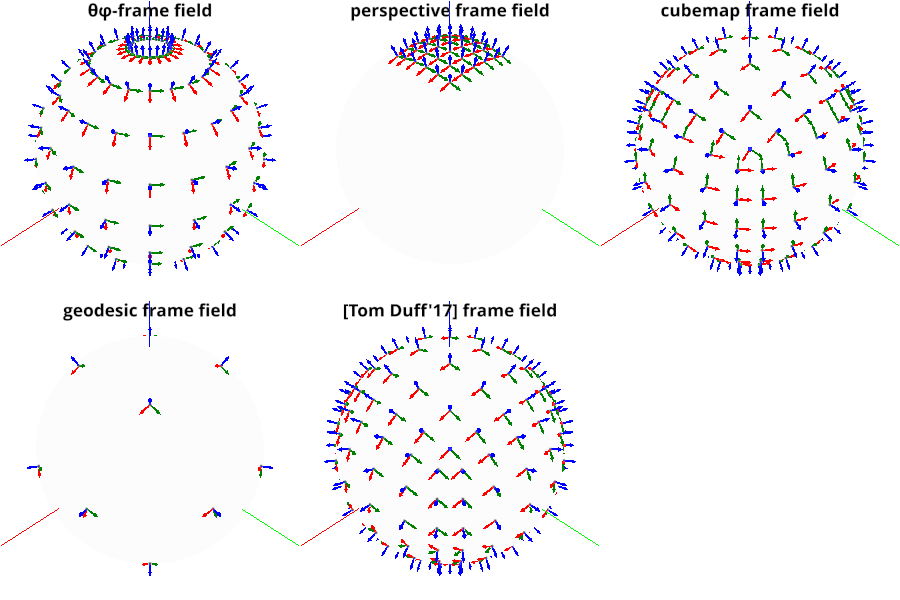

In [3]:
sphFF_er = psh.SphereFrameField.from_equirect(h, w)
assert sphFF_er.SphGrid is psh.SphereGridEquirect(h, w) # cached
assert sphFF_er is sphFF_er.SphGrid.ThetaPhiFrameField() # cached

sphFF_persp = psh.SphereFrameField.from_persp(edge, edge, 40.0, to_world)
assert np.allclose(sphFF_persp.SphGrid.vec, psh.SphereGridPersp(edge, edge, 40.0, to_world).vec) # not cached
assert np.allclose(sphFF_persp.F, sphFF_persp.SphGrid.PerspectiveFrameField(to_world[:, 1]).F) # not cached,
# `to_world[:, 1]` is the camera up vector

sphFF_cube = psh.SphereFrameField.from_cube(edge)
assert sphFF_cube.SphGrid is psh.SphereGridCube(edge) # cached
assert sphFF_cube is sphFF_cube.SphGrid.CubemapFrameField() # cached

sphFF_mirr = psh.SphereFrameField.from_mirrorball(edge)
assert sphFF_mirr.SphGrid is psh.SphereGridMirrorball(edge) # cached
assert sphFF_mirr is sphFF_mirr.SphGrid.GeodesicFrameField() # cached

sphFF_list = [sphFF_er, sphFF_persp, sphFF_cube, sphFF_mirr, sphG.TD17FrameField()]
titles = ["θφ-frame field", "perspective frame field", "cubemap frame field", "geodesic frame field", "[Tom Duff'17] frame field"]
with psh.visualize_layout(2, 3, figsize=(900, 600)):
    for i, (sphFF, title) in enumerate(zip(sphFF_list, titles)):
        sphFF.visualize(title=title, help=(i==0))

## 4.2. `StokesField` class
Core attributes:
* `.SphFF: SphereFrameField` ([*g] for shape)
* `.Stk: np.ndarray[*g, *c, p]` for (numeric) Stokes component vectors

### Constructors

StokesField[
  dom_type = <DomType.UNI: 0>,
  Stk.shape = [g:6, 64, 64 | c:3, | p:4],
]
stkF.cod_type = <CodType.POLAR4: 4>


RFBOutputContext()

[Keyboard interface]
0: texture/point cloud mode for s0 component
A: hide/show global axes


CanvasBackend(css_height='500px')
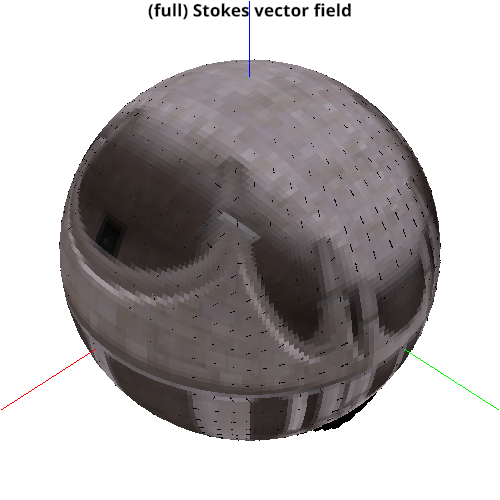

In [4]:
stkF = psh.StokesField.from_cubeimage(psh.data_dir/"sponza_64_s%d.exr")
print(stkF)
print(f"{stkF.cod_type = }")
stkF.visualize(title="(full) Stokes vector field",
               arrow_dsamp=4, arrow_scale=0.05, arrow_gamma=1/2.2)

### Stokes components (Stokes parameters) under each frame field

RFBOutputContext()

CanvasBackend(css_height='1200px', css_width='900px')
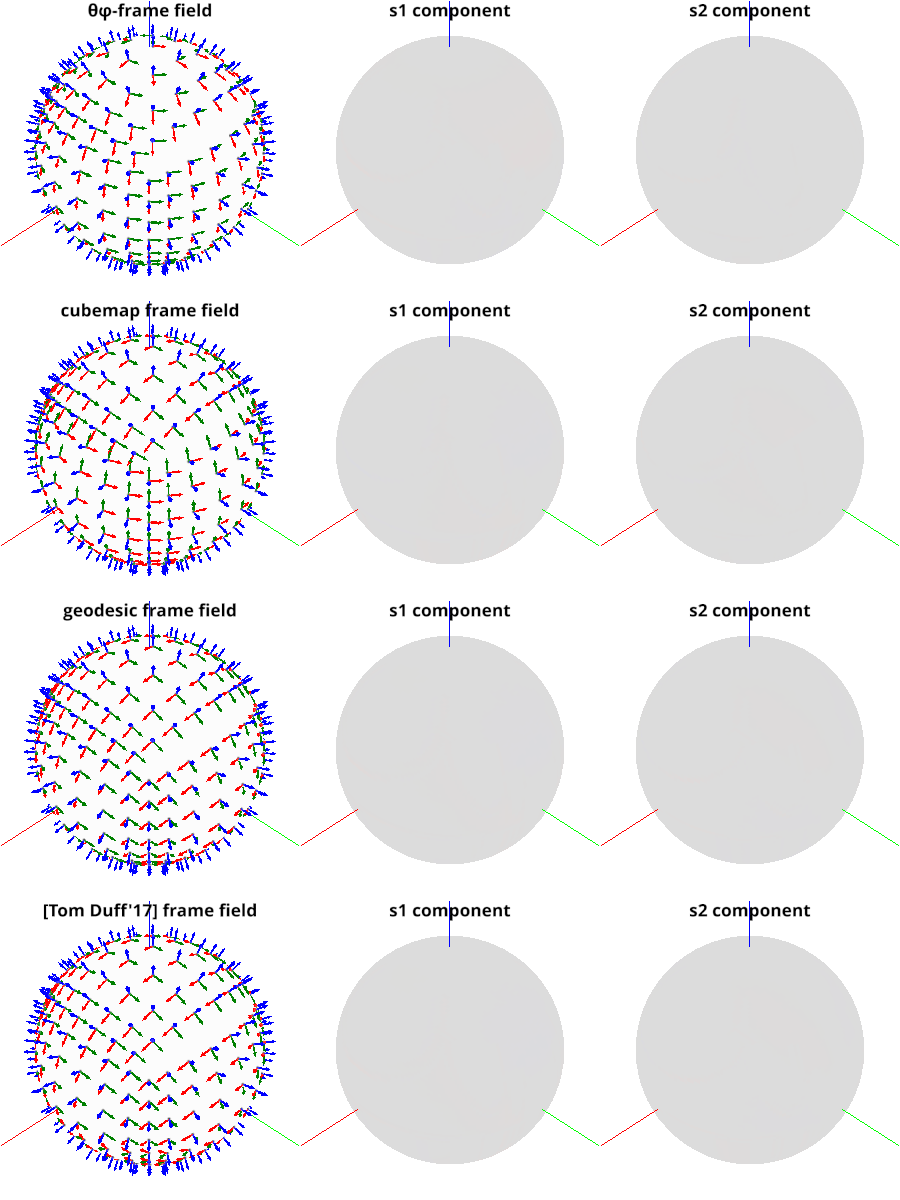

In [5]:
# ---------- Parameters ----------
dsamp = 8
if True: # You can change it to `False`
    stkF_ = stkF
else:
    """
    Since given Stokes vector field from the file `psh.data_dir/"sponza_64_s%d.exr"` has weak signals
    except a small region around the south pole,
    Differences of Stokes components with respect to some frame fields would be more visible
    when rotating the Stokes vector field.
    """
    stkF_ = stkF.apply_rotation([np.pi/2, 0, 0])

# ---------- Visualize ----------
sphG = stkF_.SphGrid
sphFF_name_list =['ThetaPhiFrameField', 'CubemapFrameField', 'GeodesicFrameField', 'TD17FrameField']
with psh.visualize_layout(len(sphFF_name_list), 3, figsize=(900, 1200)):
    for sphFF_name, title in zip(sphFF_name_list, titles[:1] + titles[2:]):
        sphFF: psh.SphereFrameField = getattr(sphG, sphFF_name)()
        sphFF.visualize(title=title, marker_dsamp=dsamp, arrow_dsamp=dsamp, help=False)
        stkF_curr = stkF_.to_SphFF(sphFF)
        
        assert stkF_.allclose(stkF_curr)
        """
        Note that the Stokes vectors, which are geometric quantities,
        themselves are considered as not to be changed
        even if their internal representation (frame field + Stokes component vectors) were changed
        """
        
        stkF_curr.s1_ScalarField().chan.rgb2gray().visualize(title="s1 component", help=False)
        stkF_curr.s2_ScalarField().chan.rgb2gray().visualize(title="s2 component", help=False)

## 4.3. Stokes vector field operations
Stokes vector operations defined in [Chapter 3. Polarization and Mueller Calculus](./3_polarization.ipynb) are naturally defined on Stokes vector *fields*.

RFBOutputContext()

CanvasBackend(css_height='600px', css_width='900px')
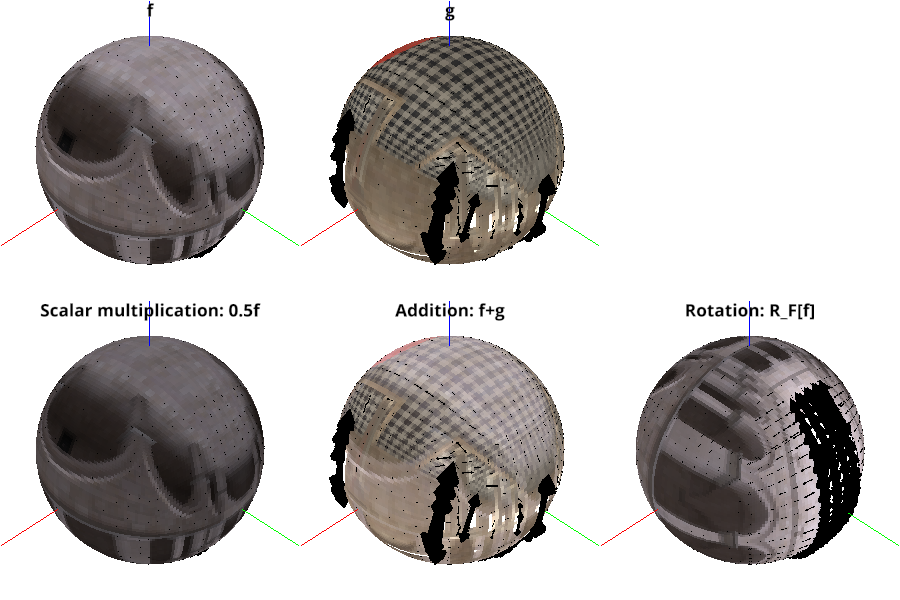

Inner product <f,g>_F: [2.45358579 1.89800891 1.71302462] (for RGB)


In [6]:
stkF2 = psh.StokesField.from_cubeimage(psh.data_dir/"cathedral_64_s%d.exr")
assert stkF.SphGrid is stkF2.SphGrid # cached constructor `psh.SphereGridCube`. See [Chapter 1. Spherical functions](./1_spherical_fucntions.ipynb)

cfg = dict(arrow_dsamp=4, arrow_scale=0.05, arrow_gamma=1/2.2, help=False)
with psh.visualize_layout(2, 3, figsize=(900, 600)):
    stkF.visualize(**cfg, title="f")
    stkF2.visualize(**cfg, title="g")
    psh.visualize_layout.skip()
    (stkF * 0.5).visualize(**cfg, title="Scalar multiplication: 0.5f")
    (stkF + stkF2).visualize(**cfg, title="Addition: f+g")
    stkF.apply_rotation([np.pi/2, 0, 0]).visualize(**cfg, title="Rotation: R_F[f]")
inner = stkF.inner(stkF2)
print(f"Inner product <f,g>_F: {inner} (for RGB)")

### Full vs. spin-2 Stokes vector fields
Separate two scalar fields and a spin-2 Stokes vector field.

RFBOutputContext()

stkF_s0 = ScalarField[
  dom_type = <DomType.UNI: 0>,
  fval.shape = [g:6, 64, 64 | c:3,],
]

stkF_s12 = StokesField[
  dom_type = <DomType.UNI: 0>,
  Stk.shape = [g:6, 64, 64 | c:3, | p:2],
]
stkF_s12.cod_type = <CodType.POLAR2: 2>

stkF_s3 = ScalarField[
  dom_type = <DomType.UNI: 0>,
  fval.shape = [g:6, 64, 64 | c:3,],
]


CanvasBackend(css_width='900px')
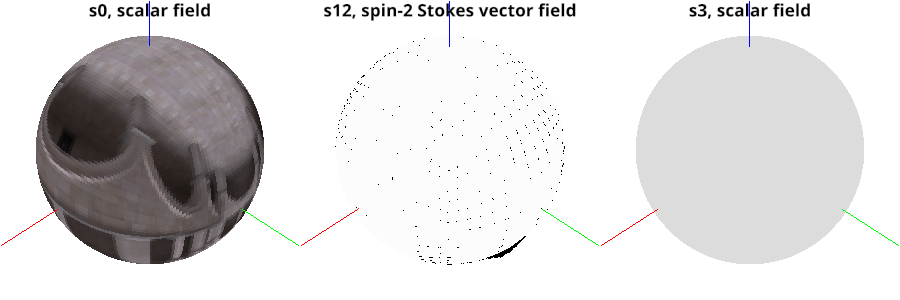

In [7]:
with psh.visualize_layout(1, 3, figsize=(900, 300)):
    stkF_s0 = stkF.s0_ScalarField()
    print(f"{stkF_s0 = }")
    stkF_s0.visualize(title="s0, scalar field", help=False)

    stkF_s12 = stkF.s12_StokesField()
    assert stkF_s12.allclose(stkF.to_CodType(psh.CodType.POLAR2))
    print(f"\n{stkF_s12 = }")
    print(f"{stkF_s12.cod_type = }")
    stkF_s12.visualize(title="s12, spin-2 Stokes vector field", **cfg)

    stkF_s3 = stkF.s3_ScalarField()
    print(f"\n{stkF_s3 = }")
    stkF_s3.chan.rgb2gray().visualize(title="s3, scalar field", help=False)

They also can be combined again. It is denoted by the direct sum $\oplus$:
$$
\begin{equation}\tag{M-p.7, S-p.31}
    \overset{\leftrightarrow} f = f_0 \oplus \overset{\leftrightarrow}f_{12} \oplus f_3
\end{equation}
$$

In [8]:
assert stkF.allclose(psh.StokesField.from_components(stkF_s0, stkF_s12, stkF_s3))

Recall [Chapter 3.3. Full vs. spin-2 Stokes vectors](./3_polarization.ipynb). Several operations are only defined on spin-2 Stokes vector fields.

Complex inner product between two spin-2 Stokes vector *fields* can be directly extended by complex inner product between two spin-2 Stokes vectors:
$$
{\left\langle \overset\leftrightarrow f, \overset\leftrightarrow g \right\rangle}_{\mathcal F\left(\hat{\mathbb S}^2, \mathcal S\right)|\mathbb C} \coloneqq \int_{\hat{\mathbb S}^2}{ {\left\langle \overset\leftrightarrow f\left(\hat\omega\right), \overset\leftrightarrow g \left(\hat\omega\right) \right\rangle}_{\mathcal S|\mathbb C} \mathrm d \hat\omega}.
$$
Here, ${\left\langle \cdot, \cdot \right\rangle}_{\mathcal F\left(\hat{\mathbb S}^2, \mathcal S\right)|\mathbb C}$ will be often written in a shorthand as ${\left\langle \cdot, \cdot \right\rangle}_{\mathcal F|\mathbb C}$.

RFBOutputContext()

CanvasBackend(css_height='500px')
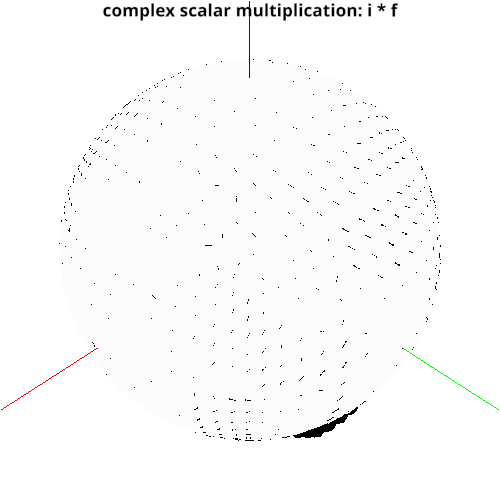

Complex inner product <f,g>_F|C: [0.41152883+0.00056461j 0.37142305+0.00043214j 0.37391346+0.00035374j] (for RGB)


In [9]:
display((stkF_s12*(1j)).visualize(**cfg, title="complex scalar multiplication: i * f"))

inner_comp = stkF_s12.inner_comp(stkF2.s12_StokesField())
print(f"Complex inner product <f,g>_F|C: {inner_comp} (for RGB)")

## 4.3. Naive approach: SH + frame field
Naively combine scalar SH and a frame field yield the singularity problem, which implies violation of rotation invariance.
Here, we use the $\theta\phi$-frame field which has singularities at the north and south poles $\pm\hat z_g$.

RFBOutputContext()

CanvasBackend(css_height='600px', css_width='1200px')
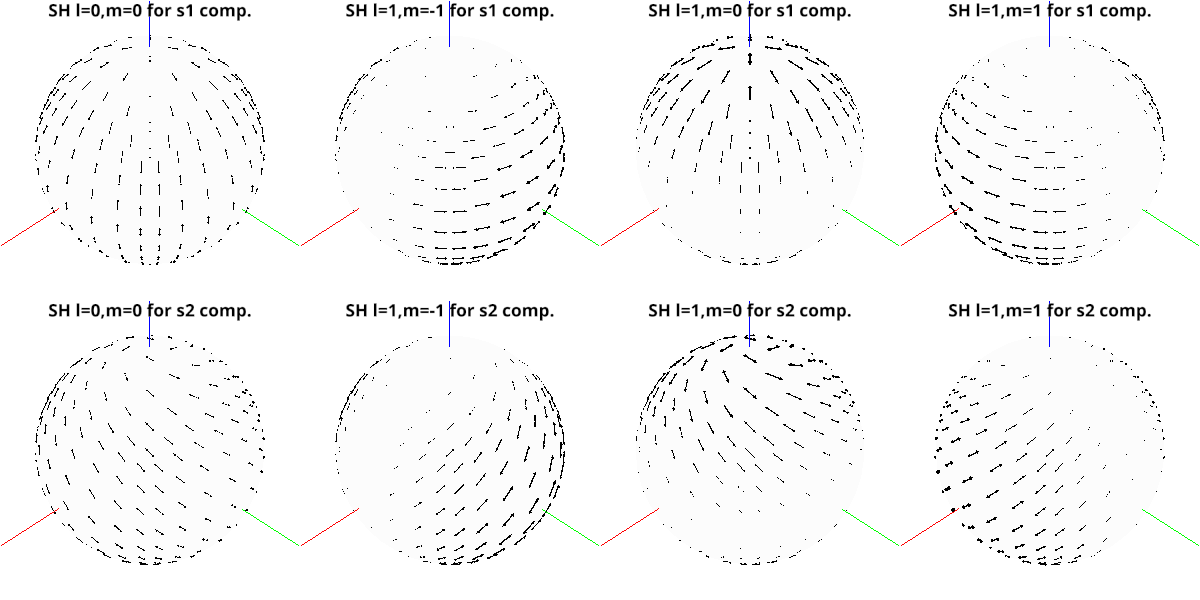

In [10]:
# --------- Parameters ----------
level = 2

# ---------- Main ----------
sphG = psh.SphereGridCube(8)
scalF_SH = psh.ScalarField.from_SH_upto(level, sphG, psh.SHType.REAL)

sphFF = sphG.ThetaPhiFrameField() # Any other kind of frame field also presents the same take-home message.
Z = np.zeros_like(scalF_SH.fval)
stkF_nvSH_s1 = psh.StokesField(sphFF, np.stack([scalF_SH.fval, Z], -1))
stkF_nvSH_s2 = psh.StokesField(sphFF, np.stack([Z, scalF_SH.fval], -1))

# ---------- visualize ----------
with psh.visualize_layout(2, level**2, figsize=(1200, 600)):
    for s, _stkF in enumerate([stkF_nvSH_s1, stkF_nvSH_s2]):
        for idx, (l,m) in enumerate(psh.level2lms(level, psh.DomType.UNI)):
            _stkF.chan[idx].visualize(title=f"SH {l=},{m=} for s{s+1} comp.", arrow_scale=0.3, help=False)

Naive SH coefficient for a Stokes vector field

In [11]:
level = 5
stkF = psh.StokesField.from_cubeimage(psh.data_dir/"sponza_64_s%d.exr")
sphG = stkF.SphGrid
sphFF = stkF.SphGrid.ThetaPhiFrameField()
stkF = stkF.to_SphFF(sphFF)
shv_nv = psh.ScalarField(stkF.SphGrid, stkF.Stk).SHCoeff(level, psh.SHType.REAL)
print(shv_nv)

SHVec[c: 3, 4 | N: 25 (SCALAR)][
  level = 5,
  cod_type = <CodType.SCALAR: 1>,
  sh_type = <SHType.REAL: 0>,
  coeff.shape = (3, 4, 25),
  coeff.dtype = float64,
]


RFBOutputContext()

[Keyboard interface]
0: texture/point cloud mode for s0 component
A: hide/show global axes


CanvasBackend(css_height='500px')
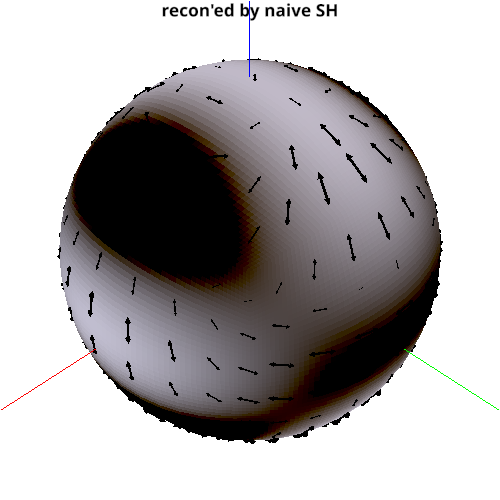

In [12]:
stkF_recon = psh.StokesField(sphFF, psh.ScalarField.from_SHCoeff(shv_nv, sphG).fval)
stkF_recon.visualize(arrow_dsamp=8, arrow_scale=0.05, arrow_gamma=1/2.2,
                     title="recon'ed by naive SH")

Naive SH rotation
First, compute rotated $\theta\phi$-frame field which has the same `.SphGrid` attribute as the original frame field.

RFBOutputContext()

[Keyboard interface]
A: hide/show global axes
G: hide/show sphere grids
F: show x(, y(, z)) axes for the frame field


CanvasBackend(css_height='500px')
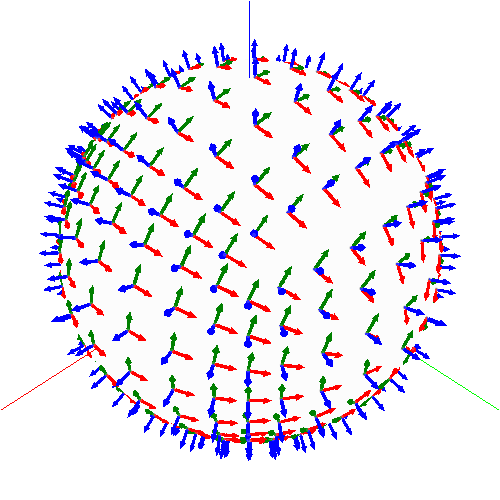

In [13]:
rotvec = [np.pi/2, 0, 0]
R = scipyRotation.from_rotvec(rotvec).as_matrix()
Ftp_rot = R @ psh.vec2Ftp(psh.matmul_vec1d(np.linalg.inv(R), sphG.vec))
sphFF_rot = psh.SphereFrameField(sphG, Ftp_rot)
sphFF_rot.visualize(arrow_dsamp=8, marker_dsamp=8)

Coefficient matrix for rotation w.r.t Naive SH: `shm_nvrot`

In [14]:
with psh.Tictoc("Construct rotaed Naive SH basis fucntions: %.4f sec."):
    scalF_SH = psh.ScalarField.from_SH_upto(level, sphG, psh.SHType.REAL)
    Z = np.zeros_like(scalF_SH.fval)
    stkF_nvSH_s1 = psh.StokesField(sphFF, np.stack([scalF_SH.fval, Z], -1))

    scalF_SH_rot = psh.ScalarField.from_SH_upto(level, sphG, psh.SHType.REAL, rotated=rotvec)
    stkF_nvSH_s1_rot = psh.StokesField(sphFF_rot, np.stack([scalF_SH_rot.fval, Z], -1))

with psh.Tictoc("Compute Naive SH coefficient matrix for a rotation: %.4f sec."):
    N = psh.level2num(level, psh.DomType.UNI) # number of pairs of (l, m)
    shm_nvrot = np.zeros((N, N), dtype=complex)
    for lmo in range(N): # rows
        for lmi in range(N): # columns
            inner_curr = stkF_nvSH_s1.chan[lmo].inner_comp(stkF_nvSH_s1_rot.chan[lmi])
            shm_nvrot[lmo, lmi] = inner_curr

Construct rotaed Naive SH basis fucntions: 0.2438 sec.
Compute Naive SH coefficient matrix for a rotation: 13.5548 sec.


Applying it to the Naive SH coefficient vector.

In [15]:
shv_nv_s03 = shv_nv.chan[..., [0, -1]]
shv_nv_s03_rot = rotvec @ shv_nv_s03

coeff_s12 = psh.vec2comp(shv_nv.chan[..., 1:3].coeff, -2)
coeff_s12_rot = psh.matmul_vec1d(shm_nvrot, coeff_s12)
coeff_s12_rot = psh.comp2vec(coeff_s12_rot, -2)
coeff_rot = np.concatenate([shv_nv_s03_rot.chan[..., 0:1].coeff,
                            coeff_s12_rot,
                            shv_nv_s03_rot.chan[:, -1:].coeff], -2)
shv_nv_rot = psh.SHVec(coeff_rot, shv_nv.cod_type, shv_nv.sh_type) # Rotated coefficient vector

We finally observe the basis obtianed by naively combinning scalar SH and a frame field does not satisfy rotation invariance.

Reconstruct rotated Naive SH coefficient vector into the angular domain: 0.1639 sec.


RFBOutputContext()

CanvasBackend(css_width='600px')
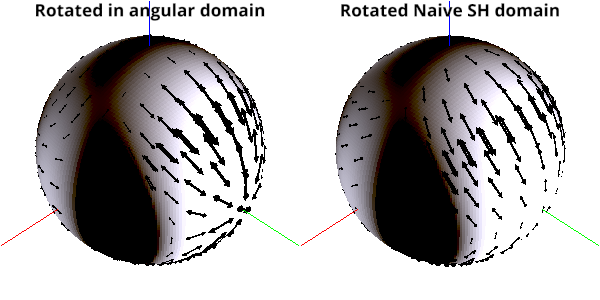

In [16]:
assert sphFF is stkF_recon.SphFF

with psh.Tictoc("Reconstruct rotated Naive SH coefficient vector into the angular domain: %.4f sec."):
    sphFF_rot = sphFF.apply_rotation(rotvec)
    sphG_rot = sphFF_rot.SphGrid
    stkF_rot_recon = psh.StokesField(sphG_rot.ThetaPhiFrameField(), psh.ScalarField.from_SHCoeff(shv_nv_rot, sphG_rot).fval).to_SphFF(sphFF_rot)

stkF_recon_rot = stkF_recon.apply_rotation(rotvec)

# ---------- Visaulize ----------
cfg = dict(arrow_dsamp=8, arrow_scale=0.05, arrow_gamma=1/2.2, help=False)
with psh.visualize_layout(1, 2, figsize=(600, 300)):
    stkF_recon_rot.visualize(**cfg, title="Rotated in angular domain")
    stkF_rot_recon.visualize(**cfg, title="Rotated Naive SH domain")